In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision

import matplotlib.pyplot as plt

In [2]:
def kl(q_mu, q_sigma, p_mu, p_sigma, eps=1e-10):
    
    res=0
    
    res += q_sigma - p_sigma + torch.exp(p_sigma - q_sigma) - 1 + (q_mu - p_mu).pow(2) / (torch.exp(q_sigma)+1e-5)
    kl_loss = res.sum(1) 
    return kl_loss

In [3]:
def log_likelihood(x, dec_output):
    
    probs = torch.clamp(dec_output, min=1e-5, max=1.-1e-5)
    log_bernoulli = x * torch.log(probs) + (1.- x) * torch.log(1. - probs)
    ll = torch.sum(log_bernoulli, 1)
    return ll

In [4]:
def batch_vlb(x, dec_output, q_mu, q_sigma):
    
    bernoulli_ll = log_likelihood(x, dec_output)
    kl_loss = kl(q_mu, q_sigma, torch.zeros_like(q_mu), torch.zeros_like(q_sigma), eps=1e-10)

    return bernoulli_ll - kl_loss

In [5]:

class Encoder(nn.Module):

    # D : number of pixels, d : latent space dimension
    def __init__(self, D, d):
        super(Encoder, self).__init__()
        self.D = D
        self.d = d

        self.input_dim = 128

        self.model = nn.Sequential(
            # your code here
            nn.Linear(D, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2*d),
        )

    # x : batch_size x D, batch of images stretched into vector
    # output: mu, sigma, both of shape batch_size x d, parameters of variational distribution
    def forward(self, x):
        mu_sigma = self.model(x) # batch_size x 2d
        mu, sigma = mu_sigma[:, :self.d], mu_sigma[:, self.d:]
        return mu, F.softplus(sigma)

In [6]:
class Decoder(nn.Module):

    def __init__(self, D, d):
        super(Decoder, self).__init__()
        self.D = D
        self.d = d

        self.sigmoid = nn.Sigmoid() # probabilities should be from 0 to 1
        self.model = nn.Sequential(
            nn.Linear(d, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, D),
        )

    # z : batch_size x d, batch of latent variables
    # output : batch_size x D, batch of parameters of Bernoulli distribution
    def forward(self, z):
        x_logits = self.model(z)
        x = self.sigmoid(x_logits)
        return x

In [7]:
def sample_latent(q_mu, q_sigma):
    # your code here
    z_sample = q_mu + torch.exp(0.5*q_sigma)*torch.randn(q_mu.shape)
    return z_sample

In [8]:
import urllib
data_link = "https://drive.google.com/file/d/12pPYZQ3jSgRhJ9ZrTlaF52fIl7hXR-fT/view?usp=sharing"
! gdown --id {urllib.parse.urlparse(data_link).path.split('/')[-2]}
! unzip mnist.zip

Downloading...
From: https://drive.google.com/uc?id=12pPYZQ3jSgRhJ9ZrTlaF52fIl7hXR-fT
To: /content/mnist.zip
34.6MB [00:00, 110MB/s] 
Archive:  mnist.zip
   creating: mnist/
  inflating: __MACOSX/._mnist        
   creating: mnist/MNIST/
  inflating: __MACOSX/mnist/._MNIST  
   creating: mnist/MNIST/processed/
  inflating: __MACOSX/mnist/MNIST/._processed  
   creating: mnist/MNIST/raw/
  inflating: __MACOSX/mnist/MNIST/._raw  
  inflating: mnist/MNIST/processed/training.pt  
  inflating: __MACOSX/mnist/MNIST/processed/._training.pt  
  inflating: mnist/MNIST/processed/test.pt  
  inflating: __MACOSX/mnist/MNIST/processed/._test.pt  
  inflating: mnist/MNIST/raw/t10k-images-idx3-ubyte  
  inflating: __MACOSX/mnist/MNIST/raw/._t10k-images-idx3-ubyte  
  inflating: mnist/MNIST/raw/t10k-labels-idx1-ubyte  
  inflating: __MACOSX/mnist/MNIST/raw/._t10k-labels-idx1-ubyte  
  inflating: mnist/MNIST/raw/train-images-idx3-ubyte  
  inflating: __MACOSX/mnist/MNIST/raw/._train-images-idx3-ubyte  

In [9]:
from torchvision.datasets import MNIST

data = MNIST(root='./mnist', download=False, train=True)
train_data_raw = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
train_data = TensorDataset(train_data_raw.tensors[0].round(), data.train_labels)
data = MNIST(root='./mnist', download=False, train=False)
test_data_raw = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)
test_data = TensorDataset(test_data_raw.tensors[0].round(), data.test_labels)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [10]:
D = 28 * 28
d = 10

In [11]:
batch_size = 64
lr = 1e-4
num_epochs = 25

In [12]:
encoder = Encoder(D, d)
decoder = Decoder(D, d)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

opt_enc = torch.optim.Adam(encoder.parameters(), lr=lr)
opt_dec = torch.optim.Adam(decoder.parameters(), lr=lr)

In [13]:
from tqdm import tqdm as tqdm

def train(dataloader, encoder, decoder, opt_enc, opt_dec, num_epochs):
    encoder.train()
    decoder.train()
    for epoch in range(num_epochs):
        with tqdm(dataloader) as iterator:
            for batch in iterator:
                X_batch, y_batch = batch

                q_mu, q_sigma = encoder(X_batch)
                z = sample_latent(q_mu, q_sigma)
                dec_output = decoder(z)

                vlb = batch_vlb(X_batch, dec_output, q_mu, q_sigma)
                loss = -vlb.mean()

                opt_enc.zero_grad()
                opt_dec.zero_grad()
                loss.backward()
                opt_enc.step()
                opt_dec.step()
                iterator.set_description('Train loss: %.3f' % loss.item())

In [14]:
train(train_dataloader, encoder, decoder, opt_enc, opt_dec, num_epochs)

Train loss: 157.830: 100%|██████████| 938/938 [00:10<00:00, 89.64it/s]


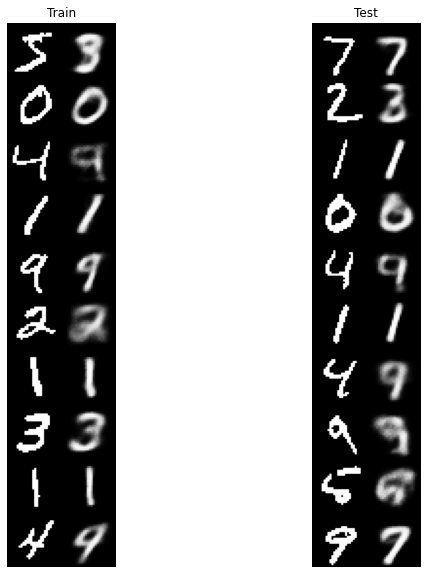

In [15]:
import numpy as np

def plot_samples(train_data, test_data, encoder, decoder, batch_size=10):
    encoder.eval()
    decoder.eval()
    digit_size = 28

    fig = plt.figure(figsize=(10, 10))
    for fid_idx, (data, title) in enumerate(
        zip([train_data, test_data], ['Train', 'Test'])):

        x_batch = data.tensors[0][:batch_size]

        mu, sigma = encoder(x_batch)
        z = sample_latent(mu, sigma)
        x_decoded = decoder(z)

        figure = np.zeros((digit_size * batch_size, digit_size * 2))
        for i in range(10):
            figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_batch[i].detach().numpy().reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size, digit_size:] = x_decoded[i].detach().numpy().reshape(digit_size, digit_size)

        ax = fig.add_subplot(1, 2, fid_idx + 1)
        ax.imshow(figure, cmap='Greys_r')
        ax.set_title(title)
        ax.axis('off')

    plt.show()
    
    
plot_samples(train_data, test_data, encoder, decoder)

In [16]:

def generate_new_samples(decoder, n_samples):
    # your code here
    z = torch.randn((n_samples, decoder.d))
    return decoder(z)

In [17]:
def show_samples(decoder, n_samples, line_width, scale=15):
    x = generate_new_samples(decoder, n_samples).detach()
    plt.figure(figsize=(scale, scale / line_width * (x.shape[0] // line_width + 1)))
    x = x.view(-1, 1, 28, 28)
    mtx = torchvision.utils.make_grid(x, nrow=line_width, pad_value=1)
    plt.imshow(mtx.permute([1, 2, 0]).numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')

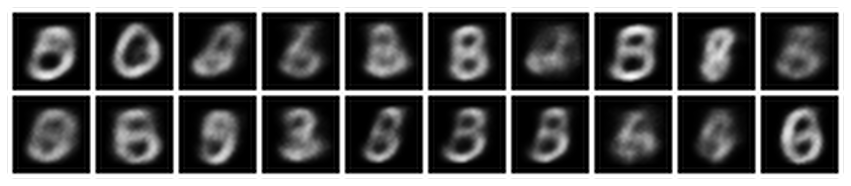

In [18]:
show_samples(decoder, n_samples=20, line_width=10)